# Data Augmentation for Segmentation

## Why is Augmentation Important?

**Data augmentation is a critical preprocessing step** for deep learning, especially for segmentation tasks like yours with drone imagery. Here's why:

### 1. **Prevents Overfitting**
- Neural networks can memorize training data instead of learning generalizable patterns
- Augmentation creates variations, forcing the model to learn robust features

### 2. **Increases Effective Dataset Size**
- Your drone dataset has limited samples
- Augmentation artificially expands the dataset without collecting new images

### 3. **Improves Model Robustness**
- **Flips**: Objects can appear in any orientation from drone perspective
- **Rotation**: Drone can capture from different angles
- **Brightness/Contrast**: Handles varying lighting conditions (day/night, shadows)
- **Noise**: Makes model robust to sensor noise and compression artifacts

### 4. **Domain-Specific Benefits for Drone Imagery**
- Drone images often have varying viewpoints and altitudes
- Environmental conditions change frequently
- Augmentation simulates these real-world variations

### Key Principle
> **Image and mask must be transformed identically** for geometric transforms (flips, rotations), but **only the image** is modified for photometric transforms (brightness, noise).

In [9]:
# Optimized Augmentation Module for Segmentation
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

def horizontal_flip(image: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Flip image and mask horizontally using OpenCV (faster than numpy)."""
    return cv2.flip(image, 1), cv2.flip(mask, 1)

def vertical_flip(image: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Flip image and mask vertically using OpenCV."""
    return cv2.flip(image, 0), cv2.flip(mask, 0)

def rotate_90(image: np.ndarray, mask: np.ndarray, k: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate image and mask by 90 degrees k times."""
    return np.rot90(image, k), np.rot90(mask, k)

def adjust_brightness_contrast(image: np.ndarray, alpha: float = 1.0, beta: int = 0) -> np.ndarray:
    """Adjust brightness (beta) and contrast (alpha) of image only."""
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def add_gaussian_noise(image: np.ndarray, mean: float = 0, std: float = 10) -> np.ndarray:
    """Add Gaussian noise to image (not mask)."""
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy = np.clip(image.astype(np.float32) + noise, 0, 255)
    return noisy.astype(np.uint8)

def random_augmentation(
    image: np.ndarray, 
    mask: np.ndarray,
    flip_prob: float = 0.5,
    rotate_prob: float = 0.3,
    brightness_prob: float = 0.3,
    noise_prob: float = 0.2
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Apply random augmentations to image and mask.
    
    Args:
        image: Input image (H, W, C)
        mask: Segmentation mask (H, W)
        flip_prob: Probability of applying flips
        rotate_prob: Probability of 90° rotation
        brightness_prob: Probability of brightness/contrast adjustment
        noise_prob: Probability of adding Gaussian noise
    
    Returns:
        Augmented image and mask
    """
    # Horizontal flip
    if np.random.rand() < flip_prob:
        image, mask = horizontal_flip(image, mask)
    
    # Vertical flip
    if np.random.rand() < flip_prob:
        image, mask = vertical_flip(image, mask)
    
    # Random 90° rotation
    if np.random.rand() < rotate_prob:
        k = np.random.randint(1, 4)  # 90, 180, or 270 degrees
        image, mask = rotate_90(image, mask, k)
    
    # Brightness/Contrast adjustment (image only)
    if np.random.rand() < brightness_prob:
        alpha = np.random.uniform(0.8, 1.2)  # Contrast
        beta = np.random.randint(-20, 20)     # Brightness
        image = adjust_brightness_contrast(image, alpha, beta)
    
    # Gaussian noise (image only)
    if np.random.rand() < noise_prob:
        image = add_gaussian_noise(image, std=np.random.uniform(5, 15))
    
    return image, mask

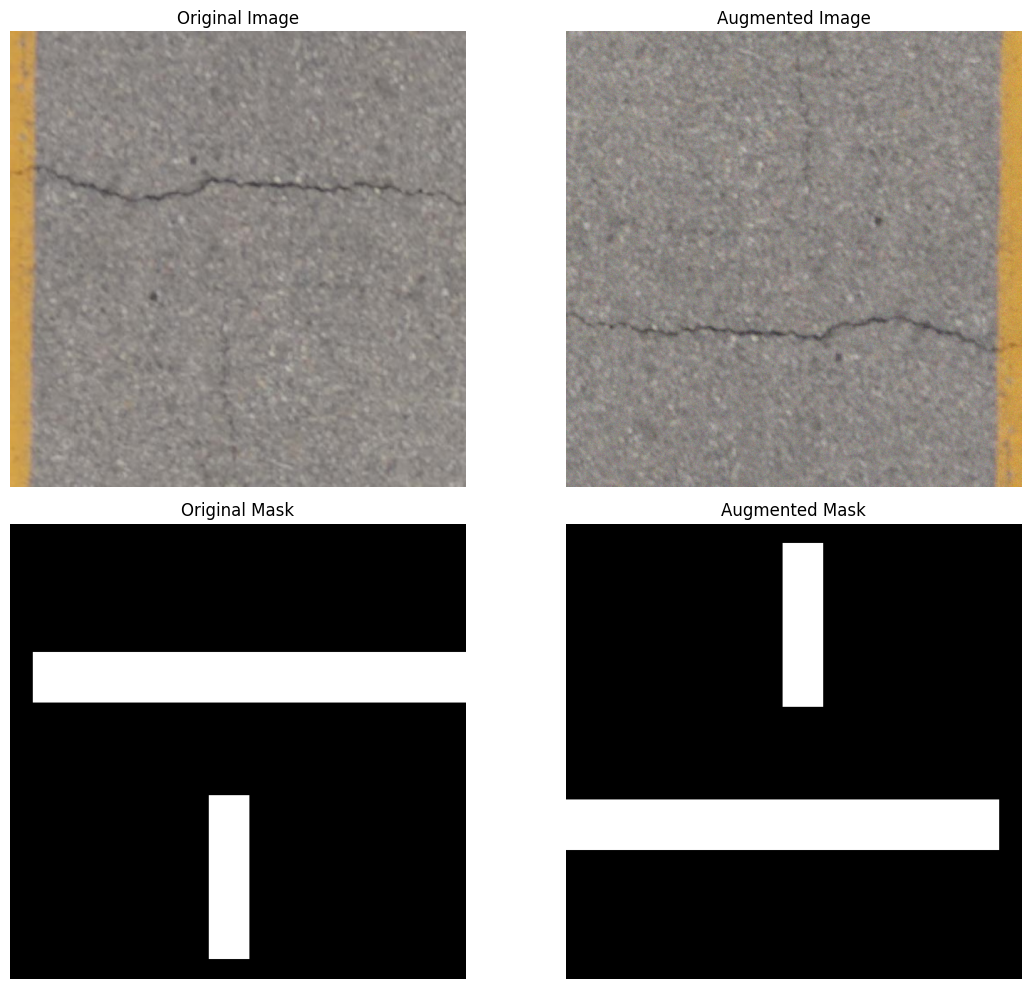

In [10]:
# Demo: Compare Original vs Augmented
img = cv2.imread("../../dataset/processed/train/images/China_Drone_000671.jpg")
mask = cv2.imread("../../dataset/segmentation/train/masks/China_Drone_000671.png", 0)

# Apply random augmentation
aug_img, aug_mask = random_augmentation(img, mask)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Augmented Image")
axes[0, 1].axis('off')

axes[1, 0].imshow(mask, cmap='gray')
axes[1, 0].set_title("Original Mask")
axes[1, 0].axis('off')

axes[1, 1].imshow(aug_mask, cmap='gray')
axes[1, 1].set_title("Augmented Mask")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()